In [11]:
import numpy as np
from spectral_cube import SpectralCube
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

from pvextractor import extract_pv_slice, Path

from astropy.coordinates import SkyCoord 
from astropy.wcs.utils import skycoord_to_pixel 
from astropy.wcs.utils import pixel_to_skycoord

import pylab as pl
from astropy import wcs

from matplotlib.patches import Ellipse

from astropy import units as u

import os
import glob
import astropy.units as u


In [12]:
cube_C18O=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/C18O/HOPS164_C18O_Tp12m7m_Combine_pbcor_masked.fits')
cube_C18O = cube_C18O.to(u.K).with_spectral_unit(u.km/u.s)
cube_C18O_pvdiagram=SpectralCube.read('/Users/ivarismartinez/Desktop/Research/REU23/ALMA/HOPS164/C18O/HOPS164_C18O_Tp12m7m_Combine_pbcor_masked.fits')

# ALMA C18O 

In [13]:
def plot_contours(fits_file, color, min_level, max_level, number_of_levels, ax):

    gamma = 2.0
    scaled_levels = np.linspace(0, 1, number_of_levels) ** gamma
    levels_continuum = min_level + (max_level - min_level) * scaled_levels
    
    return ax.contour(fits_file, colors=color, levels=levels_continuum, linewidths=0.5)

def beam(beam_minor, beam_major, beam_pa, beam_position):
    # Set beam location
    beam_x = beam_position  
    beam_y = beam_position

    # Create the beam ellipse
    return Ellipse(
        (beam_x, beam_y),
        width=beam_major,
        height=beam_minor,
        angle=beam_pa,
        edgecolor='black',
        facecolor='none',
        alpha=0.7,
        zorder=10
    )

marker_coord = SkyCoord("5h37m00.4307s", "-6d37m10.7s", frame='icrs')
x_marker, y_marker = skycoord_to_pixel(marker_coord, cube_C18O.wcs.celestial)
print(x_marker, y_marker)

228.10703615003118 221.59477267642217


In [14]:
# Chose channels with emission
v_min_C18O = 4.0
v_max_C18O = 7.5
slab_C18O = cube_C18O.spectral_slab(v_min_C18O*u.km/u.s, v_max_C18O*u.km/u.s)
slab_C18O_pvdiagram = cube_C18O_pvdiagram.spectral_slab(v_min_C18O*u.km/u.s, v_max_C18O*u.km/u.s)

# Create moment 0 map
moment0 = slab_C18O.moment(order=0)

# Access moment 0 data
data_C18O = moment0.hdu.data

In [15]:
# Given center and position angle
center = np.array([228.48949778633929, 220.43080562408412])  # (x, y)
PA = np.radians(151.02430954744995 + 90)  # Convert to radians
length = 290  #pixels

# Compute endpoint offsets along the major axis
dx = (length / 2) * np.cos(PA)
dy = (length / 2) * np.sin(PA)

# Define extended path endpoints
point1 = center + np.array([-dx, -dy])
point2 = center + np.array([dx, dy])

# Create and plot the path
path_parallel_to_disk = Path([point1, point2], width=0.5)

/Users/ivarismartinez/anaconda3/envs/umbrella/lib/python3.11/site-packages/pvextractor/geometry/path.py:262: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches.append(MPLPolygon(list(zip(poly.x, poly.y)), **kwargs))


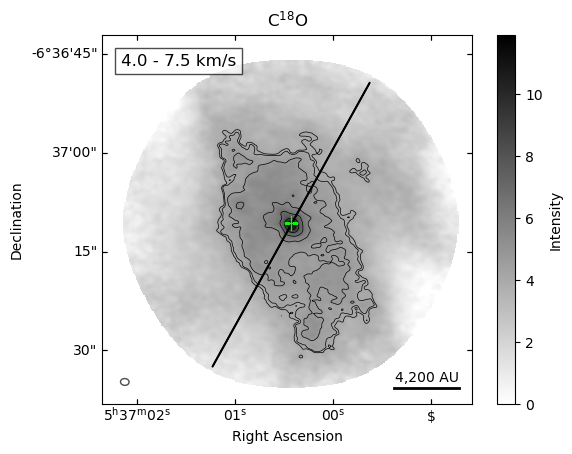

In [16]:
fig = plt.figure()
ax = pl.plt.subplot(111, projection=cube_C18O.wcs.celestial)
im = ax.imshow(data_C18O, origin='lower', cmap='binary', vmin=0)

# Plot contours
plot_contours(data_C18O, color='black', min_level=4, max_level=15, number_of_levels=9, ax=ax)

# Plot the protostar marker
ax.plot(x_marker, y_marker, marker='+', color='lime', markersize=10, label='Marker')

# Add labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.set_title(r'C$^{18}$O')

# Add velocity label in the top left of the subplot
ax.text(0.05, 0.95, f"{v_min_C18O:.1f} - {v_max_C18O:.1f} km/s", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

# Add colorbar
plt.colorbar(im, ax=ax, label='Intensity')

# Add beam
beam_C18O = beam(1.30/0.17, 1.03/0.17, 85.77, 80) #beam arcseconds times pixel arcseconds for the fits file
ax.add_patch(beam_C18O)

# Set offset limits
ax.set_xlim(60, 390) 
ax.set_ylim(60, 390)

# Set starting point for the scale bar (in arcseconds)
x_start = ax.get_xlim()[0] + 260
y_start = ax.get_ylim()[0] + 15

# Length of the bar in arcseconds
scale_bar_length = 10/0.17 # pixels (10 arcseconds in the image)

# Plot the scale bar
ax.plot([x_start, x_start + scale_bar_length], [y_start, y_start], color='black', linewidth=2)

# Label it
ax.text(x_start + scale_bar_length / 2, y_start + 3, "4,200 AU",
        color='black', ha='center', va='bottom', fontsize=10)

path_parallel_to_disk.show_on_axis(ax, spacing=1, color='black')

# Save image
# plt.savefig("HOPS164_C18O_contour_map_with_pvdiagram_path.png", format="png", dpi=300, bbox_inches="tight")

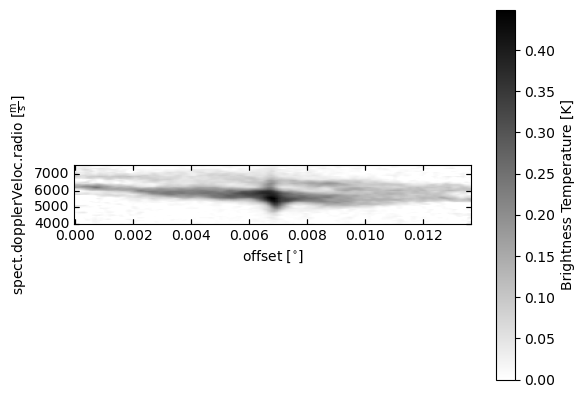

In [17]:
C18O_pvdiagram = extract_pv_slice(slab_C18O_pvdiagram, path_parallel_to_disk, spacing=1) 

ax=pl.plt.axes(111,projection=wcs.WCS(C18O_pvdiagram.header))
im=ax.imshow(C18O_pvdiagram.data, cmap='binary', vmin=0)
cb=pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

# Move ticks inside
ax.tick_params(axis='both', direction='in', which='both')

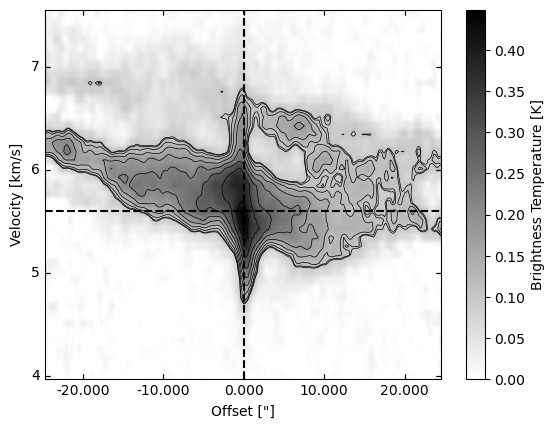

In [18]:
# Get the data array from the PV diagram
data = C18O_pvdiagram.data
ny, nx = data.shape

# Define offset and velocity axes
x_axis = np.arange(data.shape[1])  # Offset in pixels
y_axis = np.linspace(v_min_C18O, v_max_C18O, data.shape[0])  # Velocity in km/s

# Center of the offset axis (pixel 145 = 0 arcsec)
center_index = 145 # center of pvdiagram

# Update WCS header to match that center
pv_header_centered = C18O_pvdiagram.header.copy()
pv_header_centered['CRPIX1'] = center_index + 1  # 1-based FITS indexing
pv_header_centered['CRVAL1'] = 0.0  # Center at 0 arcsec

ww = wcs.WCS(pv_header_centered)

# Plot
ax = pl.plt.axes(111, projection=ww)
im = ax.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb = pl.colorbar(mappable=im)
cb.set_label('Brightness Temperature [K]')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)

ax.set_ylabel('Velocity [km/s]')
ax.set_xlabel('Offset ["]')
ax.tick_params(axis='both', direction='in', which='both')

plot_contours(C18O_pvdiagram.data, 'black', 0.1, 0.4, 9, ax=ax)

# Add guide lines
x0_pix = nx / 2
ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000 # kilometers
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Feria Models

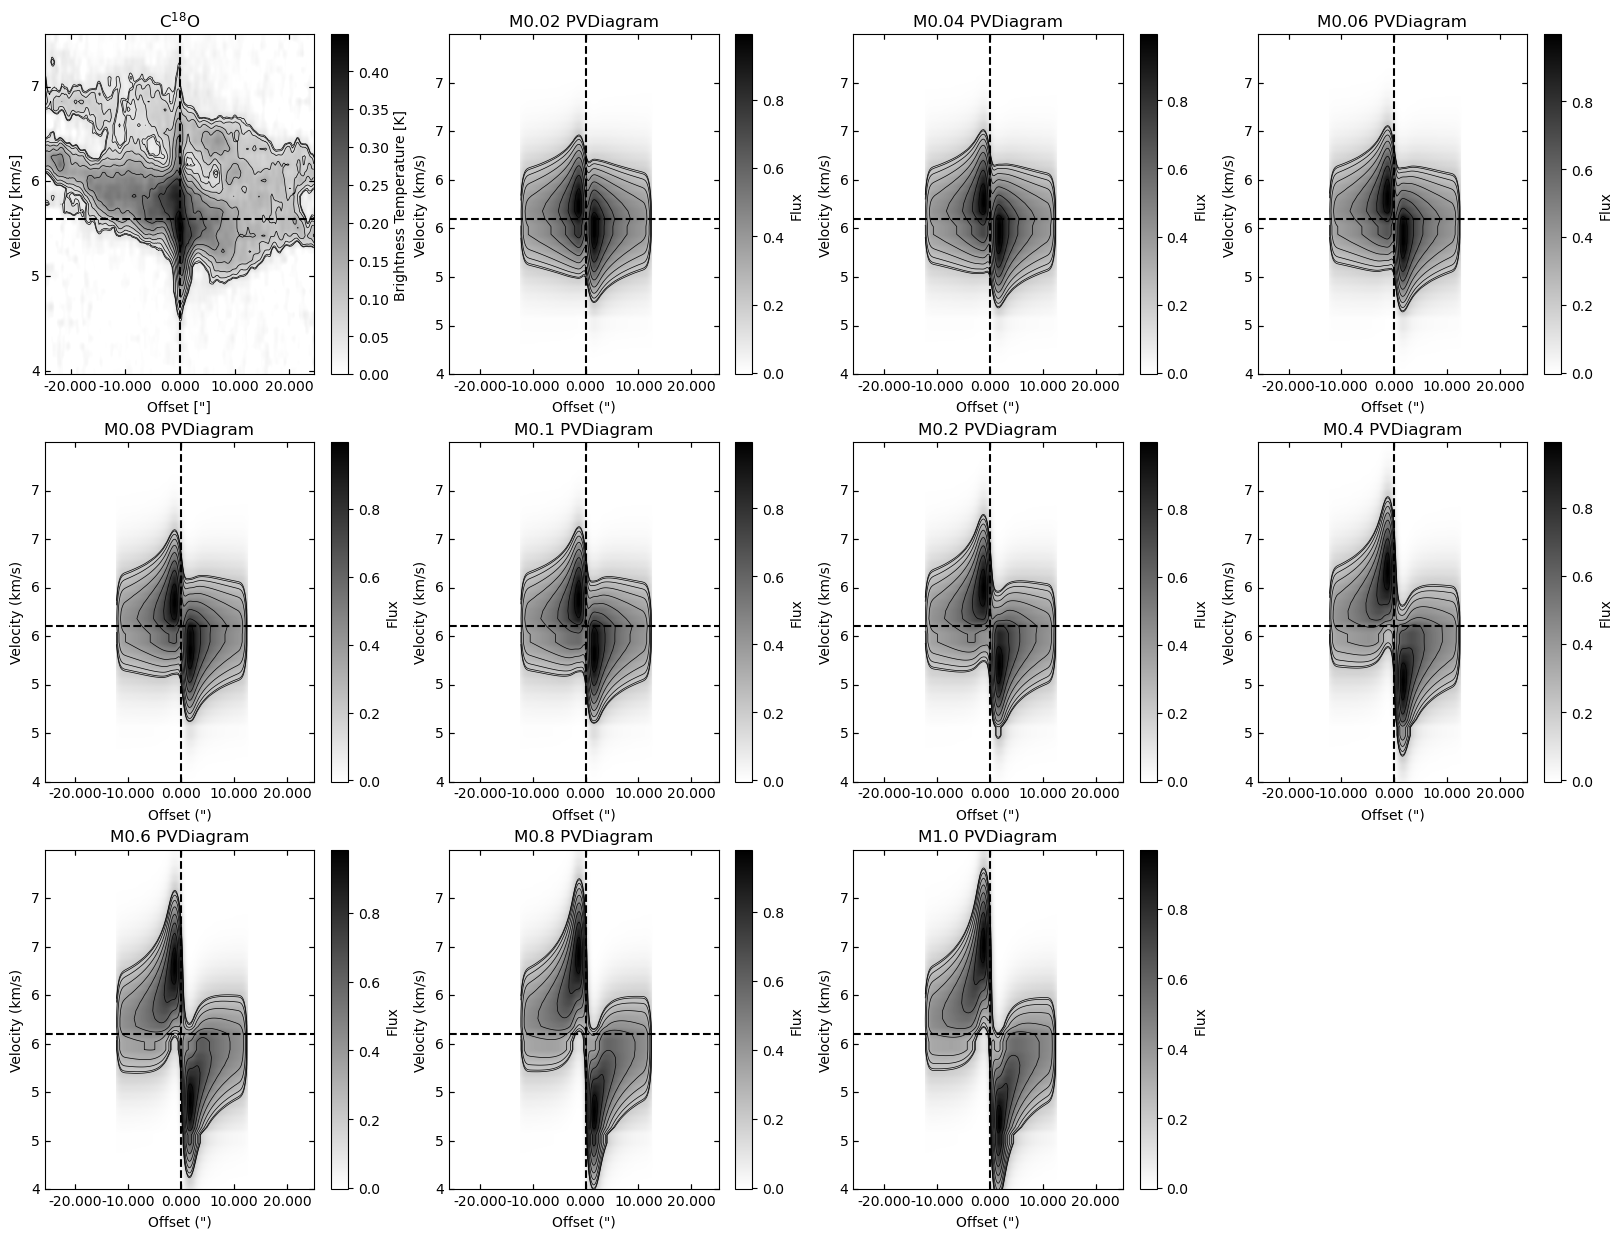

In [28]:
# Reference PV diagram
fig = plt.figure(figsize=(20, 15))  # Try wider and taller
ax0 = fig.add_subplot(3, 4, 1, projection=ww)
im0 = ax0.imshow(C18O_pvdiagram.data, aspect='auto', cmap='binary', vmin=0)
cb0 = plt.colorbar(mappable=im0, ax=ax0)
cb0.set_label('Brightness Temperature [K]')

# Axes formatting
ax0.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax0.coords[1].set_format_unit(u.km/u.s, decimal=True, show_decimal_unit=True)
ax0.set_ylabel('Velocity [km/s]')
ax0.set_xlabel('Offset ["]')
ax0.set_title(r'C$^{18}$O')
ax0.tick_params(axis='both', direction='in', which='both')

# Plot contours on reference
plot_contours(C18O_pvdiagram.data, 'black', 0.05, 0.4, 9, ax=ax0)

# Add guide lines to reference
nx = C18O_pvdiagram.data.shape[1]
x0_pix = nx / 2
ax0.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax0.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Load PV diagrams from folder
folder = "/Users/ivarismartinez/Downloads/FERIA-master"
pv_files = sorted(glob.glob(os.path.join(folder, "HOPS164-*PV-*.fits")))
titles = ["M0.02", "M0.04", "M0.06", "M0.08", "M0.1", "M0.2", "M0.4", "M0.6", "M0.8", "M1.0"]

# Iterate and plot
for i, (file, title) in enumerate(zip(pv_files, titles), start=2):  # subplot index starts at 2
    with fits.open(file) as hdul:
        pv_data = hdul[0].data
        pv_header = hdul[0].header
        wcs_pv = WCS(pv_header)

    ax = fig.add_subplot(3, 4, i, projection=wcs_pv)
    im = ax.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
    plt.colorbar(im, ax=ax, label='Flux')

    ax.set_title(f"{title} PVDiagram")
    ax.set_xlabel('Offset (")')
    ax.set_ylabel('Velocity (km/s)')

    ax.set_ylim(wcs_pv.wcs_world2pix([[0, 4e3], [0, 7.5e3]], 0)[:,1])
    ax.set_xlim(-80, 220) 

    plot_contours(pv_data, 'black', 0.2, 0.9, 9, ax=ax)

    ax.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
    ax.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

    # Add guide lines
    y_center = pv_data.shape[0] // 2
    x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
    ax.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

    x_center = pv_data.shape[1] // 2
    y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
    ax.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

    ax.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
plt.show()


# FERIA Model

# 0.02 M

In [9]:
# Find the file names
file_path = '/Users/ivarismartinez/Downloads/FERIA-master/'
cube_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.02CB600I50PA150.7849991736057Rot1Rout8400Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'
pv_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.02CB600I50PA150.7849991736057Rot1Rout17000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA150.7849991736057deg-CentRA0.Dec0..fits'

In [43]:
# Load spectral cube
cube = SpectralCube.read(cube_filename)

# Extract blue and red spectral slabs (adjust ranges as needed)
# slab_blue = cube.spectral_slab(4.0 * u.km/u.s, 5.6 * u.km/u.s)
# slab_red = cube.spectral_slab(5.6 * u.km/u.s, 8.0 * u.km/u.s)

# Compute moment 0 map for the red slab
moment0 = cube.moment(order=0)

# Get WCS for spatial axes only
cube_header = fits.getheader(cube_filename)
wcs_cube = WCS(cube_header).celestial

# # === Plotting ===
# fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': wcs_cube}, figsize=(7, 5))

# # Display the moment 0 map
# im1 = ax1.imshow(moment0.value, origin='lower', cmap='binary')
# plt.colorbar(im1, ax=ax1, label='Integrated Intensity')

# # Axis labels and title
# ax1.set_title("Moment 0 Map")
# ax1.set_xlabel("RA")
# ax1.set_ylabel("Dec")

# # Move ticks inside
# ax1.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
# plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.02CB600I50PA150.7849991736057Rot1Rout8400Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'

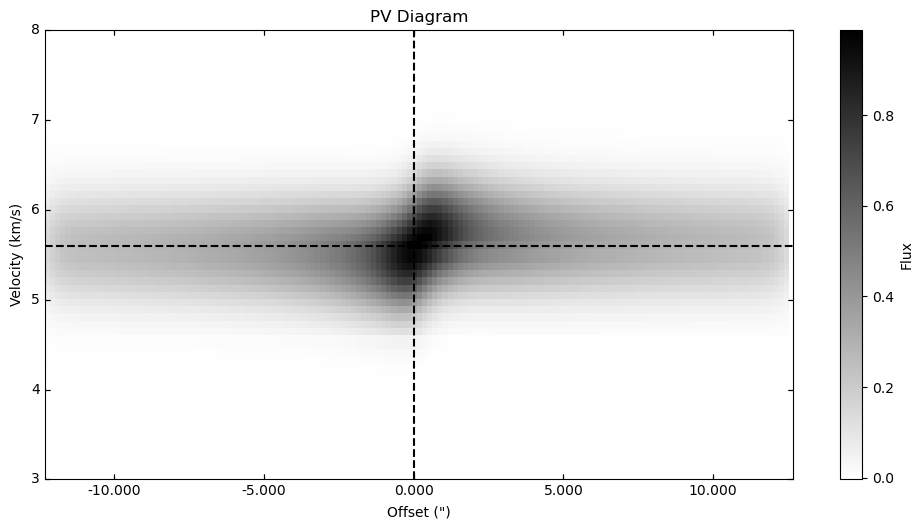

In [44]:
# Open FITS file and extract data and WCS
with fits.open(pv_filename) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 3e3], [0, 8e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()


: 

# Comparison Between FERIA and ALMA

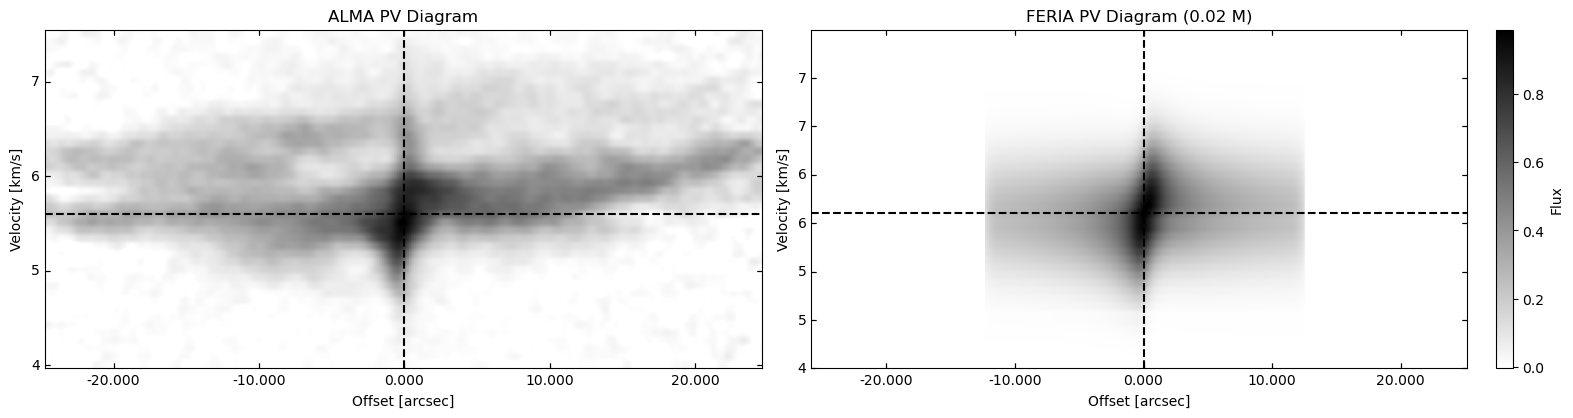

In [45]:
fig = plt.figure(figsize=(16, 16))

# === First Subplot: PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(pvdiagram_spacing_1.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

# Axis formatting
ax1.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('ALMA PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

# Add guide lines
x0_pix = nx / 2
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Second Subplot: PV Diagram (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_pv)
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')

# Axis formatting
ax2.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax2.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset [arcsec]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title('FERIA PV Diagram (0.02 M)')
ax2.tick_params(axis='both', direction='in', which='both')

# Set Y-limits using world coordinates
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, vel_min * 1e3], [0, vel_max * 1e3]], 0)[:, 1])
ax2.set_xlim(-80, 220) 

# Center and reference lines
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Add colorbar only to second image
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Flux')

plt.tight_layout()
plt.show()

: 

# 0.04 M

In [189]:
# Find the file names
file_path = '/Users/ivarismartinez/Downloads/FERIA-master/'
cube_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.04CB100.I50PA-18.28863525391Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'
pv_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.04CB100.I50PA-18.28863525391Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77_PV-PA-18.28863525391deg-CentRA0.Dec0..fits'

In [190]:
# Load spectral cube
cube = SpectralCube.read(cube_filename)

# Extract blue and red spectral slabs (adjust ranges as needed)
# slab_blue = cube.spectral_slab(4.0 * u.km/u.s, 5.6 * u.km/u.s)
# slab_red = cube.spectral_slab(5.6 * u.km/u.s, 8.0 * u.km/u.s)

# Compute moment 0 map for the red slab
moment0 = cube.moment(order=0)

# Get WCS for spatial axes only
cube_header = fits.getheader(cube_filename)
wcs_cube = WCS(cube_header).celestial

# # === Plotting ===
# fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': wcs_cube}, figsize=(7, 5))

# # Display the moment 0 map
# im1 = ax1.imshow(moment0.value, origin='lower', cmap='binary')
# plt.colorbar(im1, ax=ax1, label='Integrated Intensity')

# # Axis labels and title
# ax1.set_title("Moment 0 Map")
# ax1.set_xlabel("RA")
# ax1.set_ylabel("Dec")

# # Move ticks inside
# ax1.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
# plt.show()


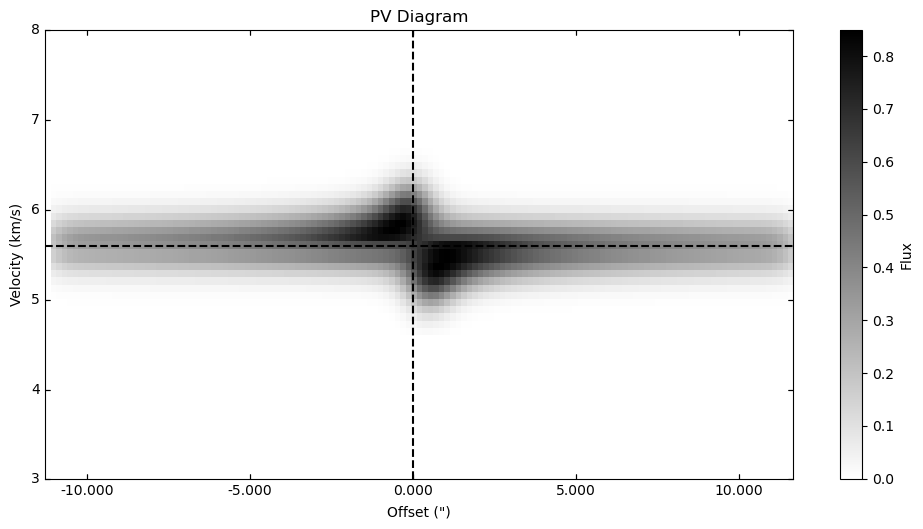

In [191]:
# Open FITS file and extract data and WCS
with fits.open(pv_filename) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 3e3], [0, 8e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()


# Comparison Between FERIA and ALMA

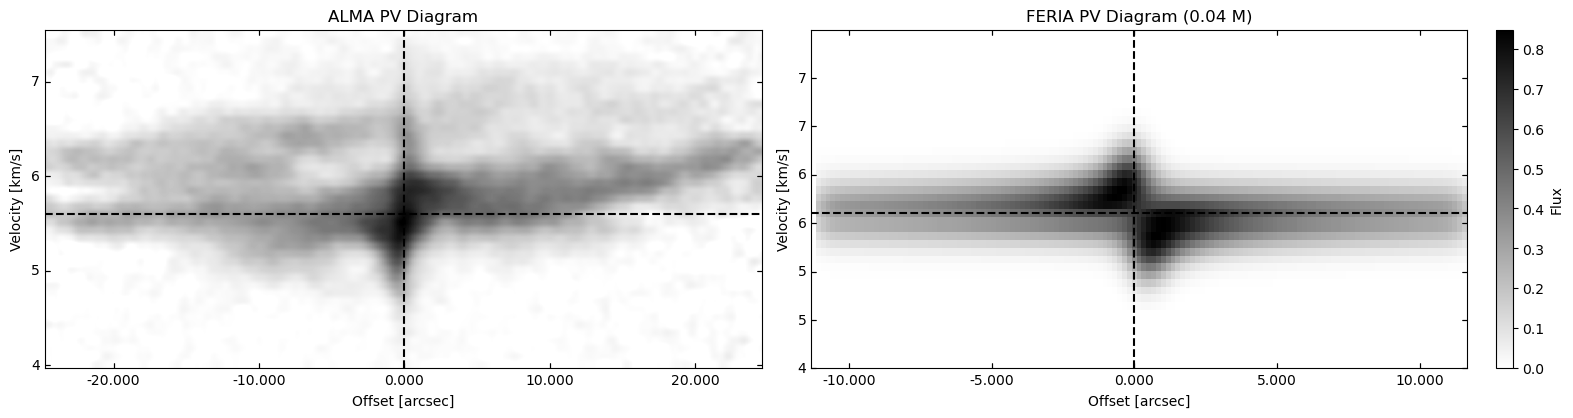

In [192]:
fig = plt.figure(figsize=(16, 16))

# === First Subplot: PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(pvdiagram_spacing_1.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

# Axis formatting
ax1.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('ALMA PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

# Add guide lines
x0_pix = nx / 2
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Second Subplot: PV Diagram (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_pv)
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')

# Axis formatting
ax2.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax2.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset [arcsec]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title('FERIA PV Diagram (0.04 M)')
ax2.tick_params(axis='both', direction='in', which='both')

# Set Y-limits using world coordinates
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, vel_min * 1e3], [0, vel_max * 1e3]], 0)[:, 1])

# Center and reference lines
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Add colorbar only to second image
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Flux')

plt.tight_layout()
plt.show()

# 0.06 M

In [160]:
# Find the file names
file_path = '/Users/ivarismartinez/Downloads/FERIA-master/'
cube_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'
pv_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77_PV-PA-18.28863525391deg-CentRA0.Dec0..fits'

In [161]:
# Load spectral cube
cube = SpectralCube.read(cube_filename)

# Extract blue and red spectral slabs (adjust ranges as needed)
# slab_blue = cube.spectral_slab(4.0 * u.km/u.s, 5.6 * u.km/u.s)
# slab_red = cube.spectral_slab(5.6 * u.km/u.s, 8.0 * u.km/u.s)

# Compute moment 0 map for the red slab
moment0 = cube.moment(order=0)

# Get WCS for spatial axes only
cube_header = fits.getheader(cube_filename)
wcs_cube = WCS(cube_header).celestial

# # === Plotting ===
# fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': wcs_cube}, figsize=(7, 5))

# # Display the moment 0 map
# im1 = ax1.imshow(moment0.value, origin='lower', cmap='binary')
# plt.colorbar(im1, ax=ax1, label='Integrated Intensity')

# # Axis labels and title
# ax1.set_title("Moment 0 Map")
# ax1.set_xlabel("RA")
# ax1.set_ylabel("Dec")

# # Move ticks inside
# ax1.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
# plt.show()


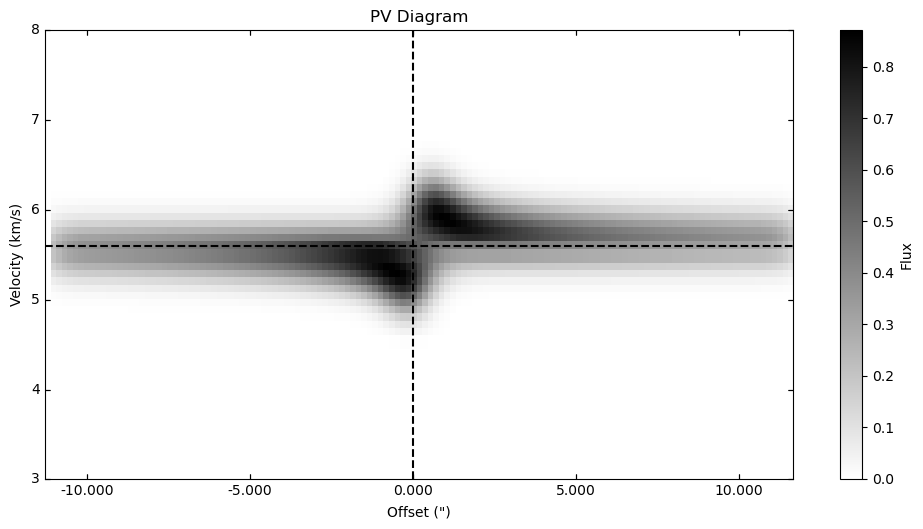

In [162]:
# Open FITS file and extract data and WCS
with fits.open(pv_filename) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 3e3], [0, 8e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()


# Comparison Between FERIA and ALMA

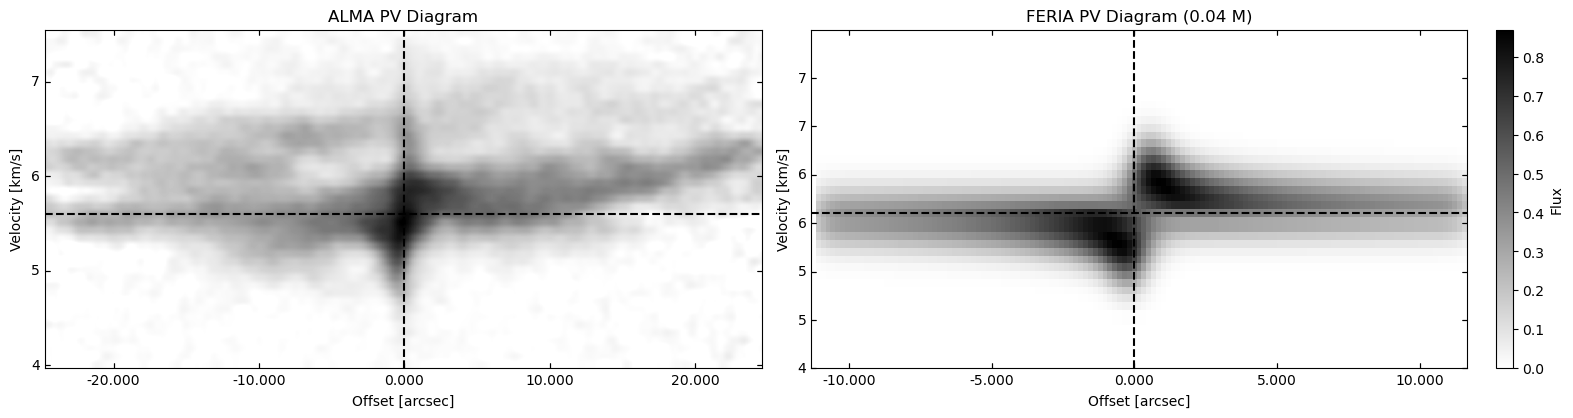

In [ ]:
fig = plt.figure(figsize=(16, 16))

# === First Subplot: PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(pvdiagram_spacing_1.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

# Axis formatting
ax1.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('ALMA PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

# Add guide lines
x0_pix = nx / 2
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Second Subplot: PV Diagram (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_pv)
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')

# Axis formatting
ax2.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax2.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset [arcsec]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title('FERIA PV Diagram (0.06 M)')
ax2.tick_params(axis='both', direction='in', which='both')

# Set Y-limits using world coordinates
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, vel_min * 1e3], [0, vel_max * 1e3]], 0)[:, 1])

# Center and reference lines
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Add colorbar only to second image
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Flux')

plt.tight_layout()
plt.show()

# 0.08 M

In [164]:
# Find the file names
file_path = '/Users/ivarismartinez/Downloads/FERIA-master/'
cube_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.08CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'
pv_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.08CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77_PV-PA-18.28863525391deg-CentRA0.Dec0..fits'

In [165]:
# Load spectral cube
cube = SpectralCube.read(cube_filename)

# Extract blue and red spectral slabs (adjust ranges as needed)
# slab_blue = cube.spectral_slab(4.0 * u.km/u.s, 5.6 * u.km/u.s)
# slab_red = cube.spectral_slab(5.6 * u.km/u.s, 8.0 * u.km/u.s)

# Compute moment 0 map for the red slab
moment0 = cube.moment(order=0)

# Get WCS for spatial axes only
cube_header = fits.getheader(cube_filename)
wcs_cube = WCS(cube_header).celestial

# # === Plotting ===
# fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': wcs_cube}, figsize=(7, 5))

# # Display the moment 0 map
# im1 = ax1.imshow(moment0.value, origin='lower', cmap='binary')
# plt.colorbar(im1, ax=ax1, label='Integrated Intensity')

# # Axis labels and title
# ax1.set_title("Moment 0 Map")
# ax1.set_xlabel("RA")
# ax1.set_ylabel("Dec")

# # Move ticks inside
# ax1.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
# plt.show()


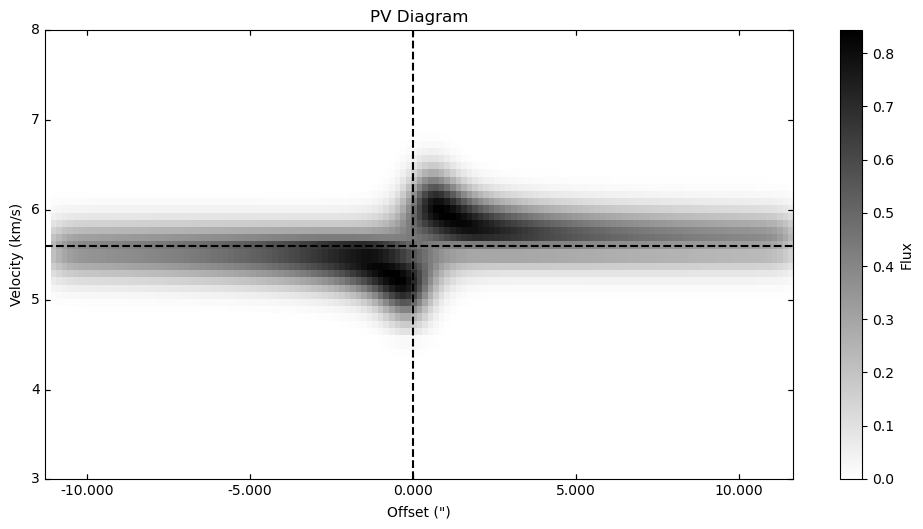

In [166]:
# Open FITS file and extract data and WCS
with fits.open(pv_filename) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 3e3], [0, 8e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()


# Comparison Between FERIA and ALMA

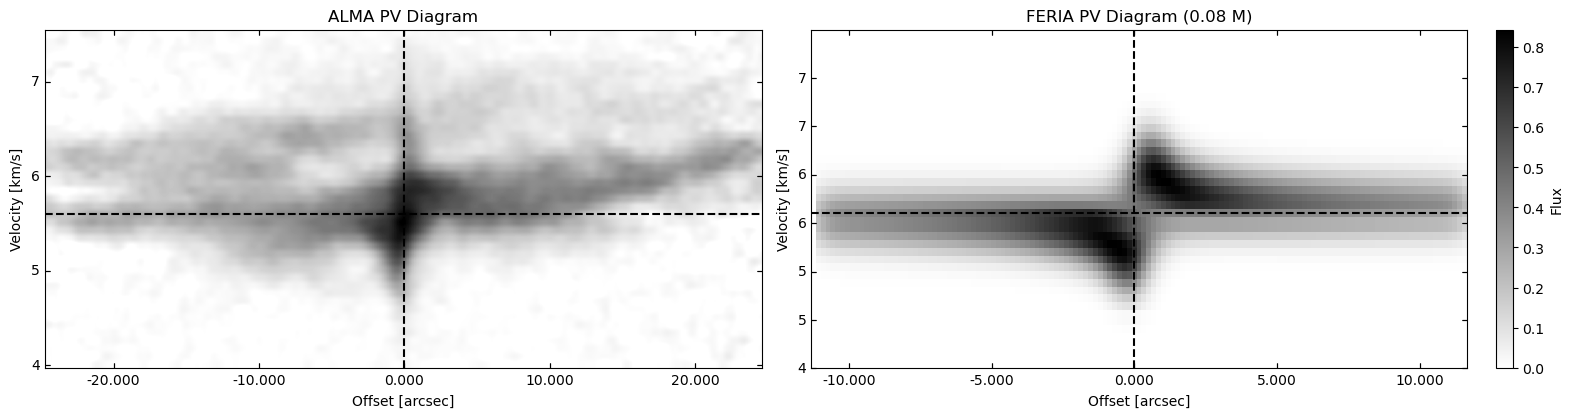

In [168]:
fig = plt.figure(figsize=(16, 16))

# === First Subplot: PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(pvdiagram_spacing_1.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

# Axis formatting
ax1.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('ALMA PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

# Add guide lines
x0_pix = nx / 2
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Second Subplot: PV Diagram (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_pv)
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')

# Axis formatting
ax2.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax2.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset [arcsec]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title('FERIA PV Diagram (0.08 M)')
ax2.tick_params(axis='both', direction='in', which='both')

# Set Y-limits using world coordinates
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, vel_min * 1e3], [0, vel_max * 1e3]], 0)[:, 1])

# Center and reference lines
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Add colorbar only to second image
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Flux')

plt.tight_layout()
plt.show()

# 0.1 M

In [169]:
# Find the file names
file_path = '/Users/ivarismartinez/Downloads/FERIA-master/'
cube_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.1CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'
pv_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.1CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77_PV-PA-18.28863525391deg-CentRA0.Dec0..fits'

In [170]:
# Load spectral cube
cube = SpectralCube.read(cube_filename)

# Extract blue and red spectral slabs (adjust ranges as needed)
# slab_blue = cube.spectral_slab(4.0 * u.km/u.s, 5.6 * u.km/u.s)
# slab_red = cube.spectral_slab(5.6 * u.km/u.s, 8.0 * u.km/u.s)

# Compute moment 0 map for the red slab
moment0 = cube.moment(order=0)

# Get WCS for spatial axes only
cube_header = fits.getheader(cube_filename)
wcs_cube = WCS(cube_header).celestial

# # === Plotting ===
# fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': wcs_cube}, figsize=(7, 5))

# # Display the moment 0 map
# im1 = ax1.imshow(moment0.value, origin='lower', cmap='binary')
# plt.colorbar(im1, ax=ax1, label='Integrated Intensity')

# # Axis labels and title
# ax1.set_title("Moment 0 Map")
# ax1.set_xlabel("RA")
# ax1.set_ylabel("Dec")

# # Move ticks inside
# ax1.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
# plt.show()


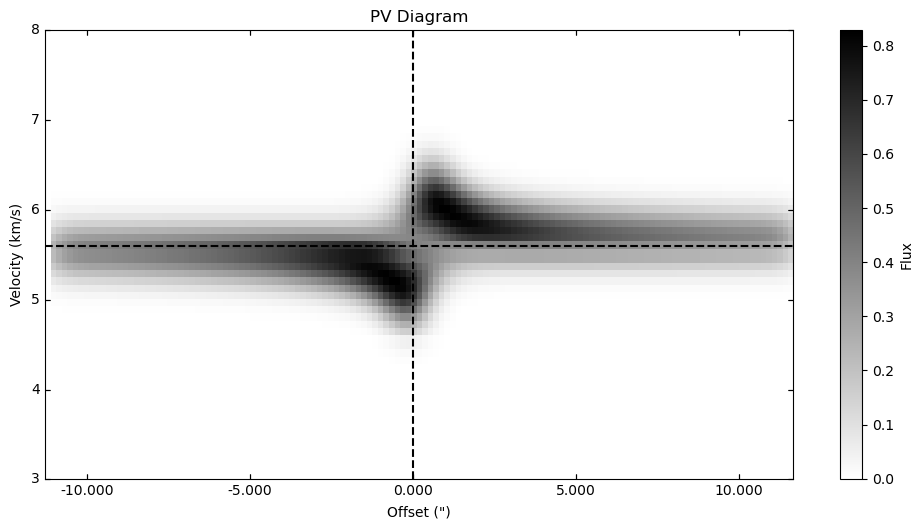

In [171]:
# Open FITS file and extract data and WCS
with fits.open(pv_filename) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 3e3], [0, 8e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()


# Comparison Between FERIA and ALMA

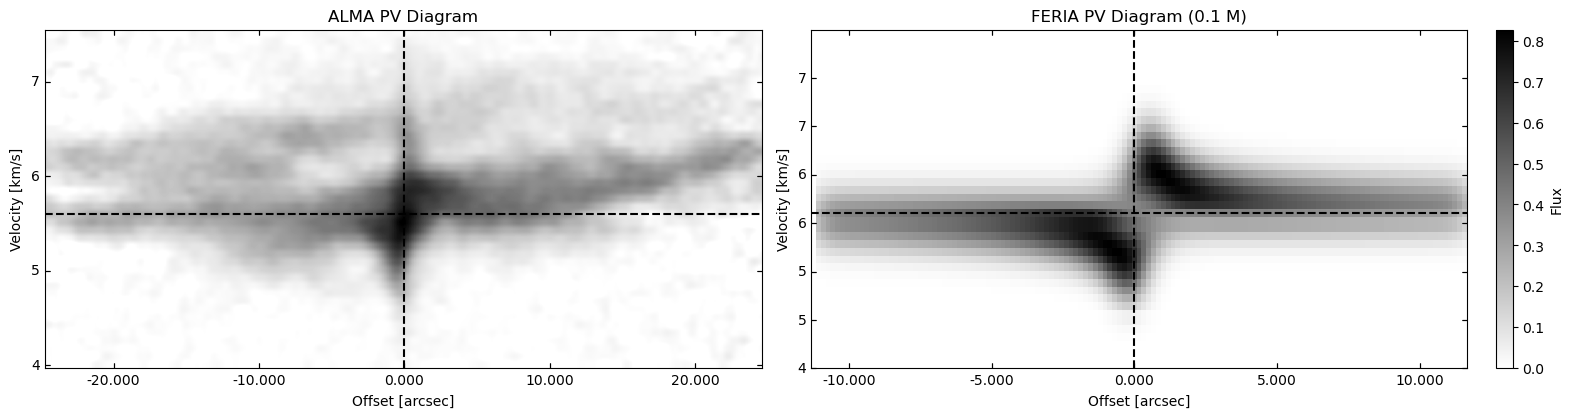

In [173]:
fig = plt.figure(figsize=(16, 16))

# === First Subplot: PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(pvdiagram_spacing_1.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

# Axis formatting
ax1.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('ALMA PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

# Add guide lines
x0_pix = nx / 2
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Second Subplot: PV Diagram (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_pv)
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')

# Axis formatting
ax2.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax2.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset [arcsec]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title('FERIA PV Diagram (0.1 M)')
ax2.tick_params(axis='both', direction='in', which='both')

# Set Y-limits using world coordinates
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, vel_min * 1e3], [0, vel_max * 1e3]], 0)[:, 1])

# Center and reference lines
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Add colorbar only to second image
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Flux')

plt.tight_layout()
plt.show()

# 0.2 M

In [174]:
# Find the file names
file_path = '/Users/ivarismartinez/Downloads/FERIA-master/'
cube_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.2CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'
pv_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.2CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77_PV-PA-18.28863525391deg-CentRA0.Dec0..fits'

In [175]:
# Load spectral cube
cube = SpectralCube.read(cube_filename)

# Extract blue and red spectral slabs (adjust ranges as needed)
# slab_blue = cube.spectral_slab(4.0 * u.km/u.s, 5.6 * u.km/u.s)
# slab_red = cube.spectral_slab(5.6 * u.km/u.s, 8.0 * u.km/u.s)

# Compute moment 0 map for the red slab
moment0 = cube.moment(order=0)

# Get WCS for spatial axes only
cube_header = fits.getheader(cube_filename)
wcs_cube = WCS(cube_header).celestial

# # === Plotting ===
# fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': wcs_cube}, figsize=(7, 5))

# # Display the moment 0 map
# im1 = ax1.imshow(moment0.value, origin='lower', cmap='binary')
# plt.colorbar(im1, ax=ax1, label='Integrated Intensity')

# # Axis labels and title
# ax1.set_title("Moment 0 Map")
# ax1.set_xlabel("RA")
# ax1.set_ylabel("Dec")

# # Move ticks inside
# ax1.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
# plt.show()


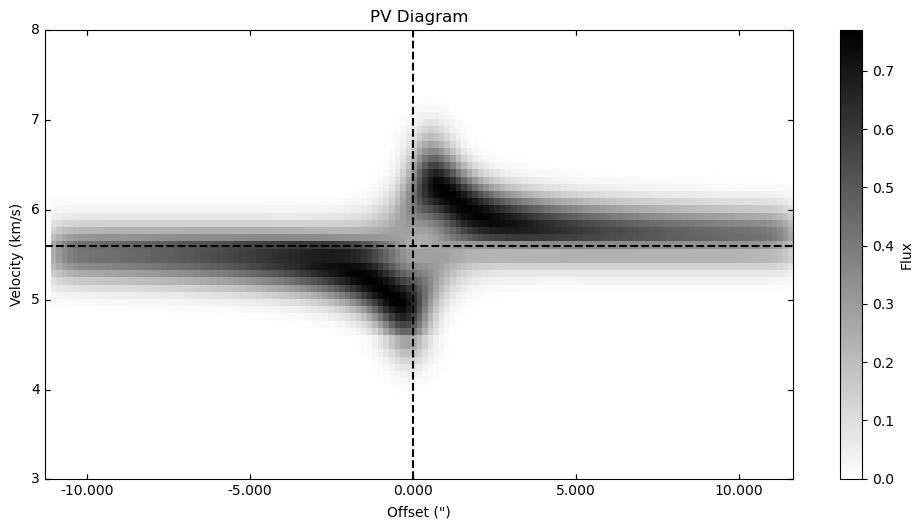

In [176]:
# Open FITS file and extract data and WCS
with fits.open(pv_filename) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 3e3], [0, 8e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()


# Comparison Between FERIA and ALMA

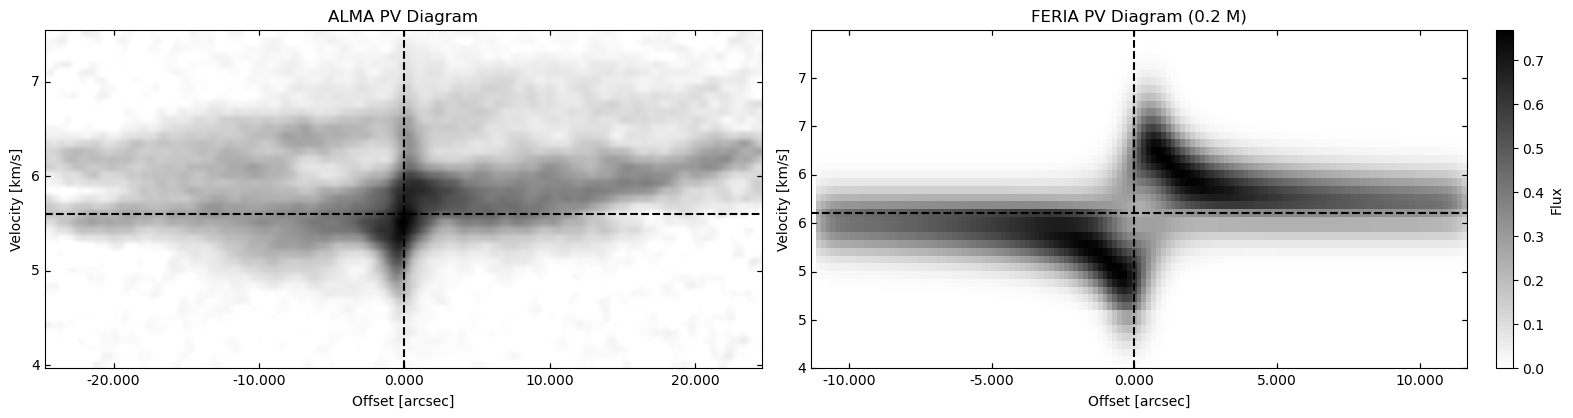

In [178]:
fig = plt.figure(figsize=(16, 16))

# === First Subplot: PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(pvdiagram_spacing_1.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

# Axis formatting
ax1.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('ALMA PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

# Add guide lines
x0_pix = nx / 2
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Second Subplot: PV Diagram (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_pv)
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')

# Axis formatting
ax2.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax2.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset [arcsec]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title('FERIA PV Diagram (0.2 M)')
ax2.tick_params(axis='both', direction='in', which='both')

# Set Y-limits using world coordinates
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, vel_min * 1e3], [0, vel_max * 1e3]], 0)[:, 1])

# Center and reference lines
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Add colorbar only to second image
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Flux')

plt.tight_layout()
plt.show()

# 0.4 M

In [179]:
# Find the file names
file_path = '/Users/ivarismartinez/Downloads/FERIA-master/'
cube_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.4CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77.fits'
pv_filename = file_path + 'HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.4CB100.I50PA150.8Rot-1Rout10000Rin0_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW0.5_Beam1.30x1.03PA85.77_PV-PA-18.28863525391deg-CentRA0.Dec0..fits'

In [180]:
# Load spectral cube
cube = SpectralCube.read(cube_filename)

# Extract blue and red spectral slabs (adjust ranges as needed)
# slab_blue = cube.spectral_slab(4.0 * u.km/u.s, 5.6 * u.km/u.s)
# slab_red = cube.spectral_slab(5.6 * u.km/u.s, 8.0 * u.km/u.s)

# Compute moment 0 map for the red slab
moment0 = cube.moment(order=0)

# Get WCS for spatial axes only
cube_header = fits.getheader(cube_filename)
wcs_cube = WCS(cube_header).celestial

# # === Plotting ===
# fig, ax1 = plt.subplots(1, 1, subplot_kw={'projection': wcs_cube}, figsize=(7, 5))

# # Display the moment 0 map
# im1 = ax1.imshow(moment0.value, origin='lower', cmap='binary')
# plt.colorbar(im1, ax=ax1, label='Integrated Intensity')

# # Axis labels and title
# ax1.set_title("Moment 0 Map")
# ax1.set_xlabel("RA")
# ax1.set_ylabel("Dec")

# # Move ticks inside
# ax1.tick_params(axis='both', direction='in', which='both')

# plt.tight_layout()
# plt.show()


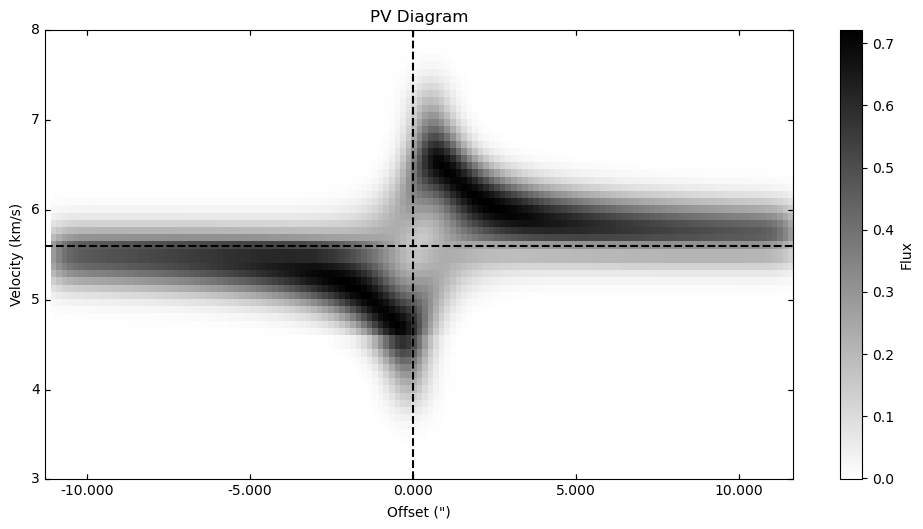

In [181]:
# Open FITS file and extract data and WCS
with fits.open(pv_filename) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 3e3], [0, 8e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()


# Comparison Between FERIA and ALMA

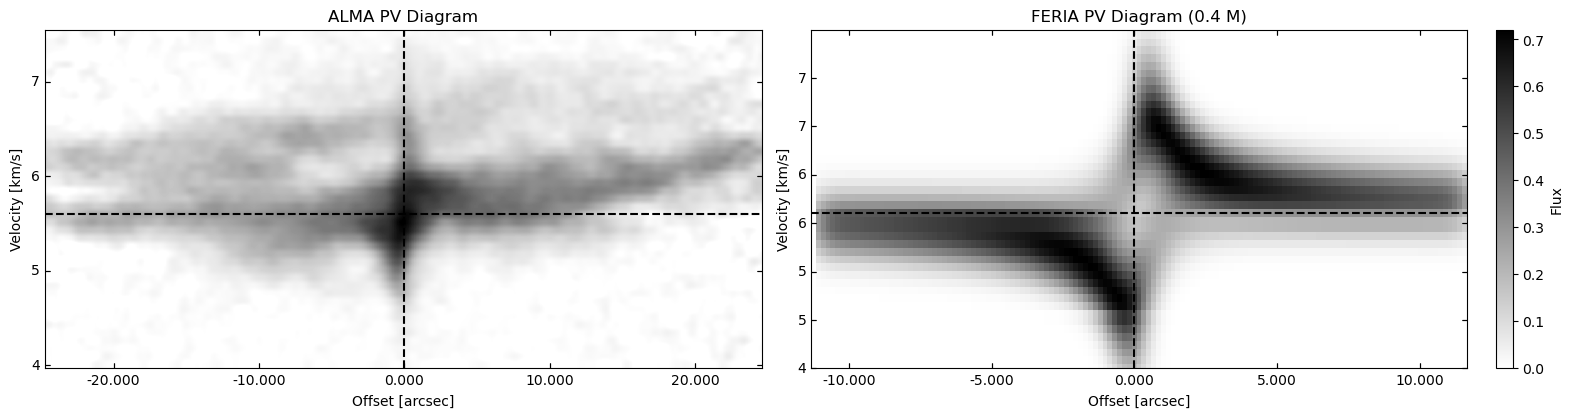

In [183]:
fig = plt.figure(figsize=(16, 16))

# === First Subplot: PV Diagram (ax1) ===
ax1 = fig.add_subplot(1, 2, 1, projection=ww)
im1 = ax1.imshow(pvdiagram_spacing_1.data, aspect='auto', cmap='binary', vmin=0, origin='lower')

# Axis formatting
ax1.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax1.set_xlabel('Offset [arcsec]')
ax1.set_ylabel('Velocity [km/s]')
ax1.set_title('ALMA PV Diagram')
ax1.tick_params(axis='both', direction='in', which='both')

# Add guide lines
x0_pix = nx / 2
ax1.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = nx // 2
y56_pix = ww.wcs_world2pix([[ww.wcs_pix2world([[x_center, 0]], 0)[0][0], velocity_mps]], 0)[0][1]
ax1.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# === Second Subplot: PV Diagram (ax2) ===
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_pv)
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')

# Axis formatting
ax2.coords[0].set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax2.coords[1].set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

ax2.set_xlabel('Offset [arcsec]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_title('FERIA PV Diagram (0.4 M)')
ax2.tick_params(axis='both', direction='in', which='both')

# Set Y-limits using world coordinates
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, vel_min * 1e3], [0, vel_max * 1e3]], 0)[:, 1])

# Center and reference lines
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]
ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]
ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Add colorbar only to second image
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Flux')

plt.tight_layout()
plt.show()

In [4]:
# Locate relevant MRT files
path = '/Users/ivarismartinez/Downloads/FERIA-master/'
zfile = glob(path + 'HOPS164-*.fits') #Define search pattern for MRT files and retrieve matching files
print(len(zfile)) # Print count of files found

14


In [5]:
zfile # Print list of matched files

['/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA241deg-CentRA0.Dec0..fits',
 '/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.04CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA241deg-CentRA0.Dec0..fits',
 '/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.2CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA241deg-CentRA0.Dec0..fits',
 '/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77.fits',
 '/Users/iv

In [13]:
# Search for a specific MRT file containing M0.02 and PV
for file in zfile:
    if 'M0.02' and 'PV'in file:
        HOPS164_M002_pvdiagram = file # Read file in ECSV format
        print(HOPS164_M002_pvdiagram) # Print contents of the file
        break  # Exit the loop once the file is found

else:
    print("File with 'PV' not found.") # Print message if no file is found

# Search for a specific MRT file containing M0.04 and PV
for file in zfile:
    if 'M0.04' and 'PV'in file:
        HOPS164_M004_pvdiagram = file # Read file in ECSV format
        print(HOPS164_M004_pvdiagram) # Print contents of the file
        break  # Exit the loop once the file is found

else:
    print("File with 'PV' not found.") # Print message if no file is found

# Search for a specific MRT file containing M0.06 and PV
for file in zfile:
    if 'M0.06' and 'PV'in file:
        HOPS164_M006_pvdiagram = file # Read file in ECSV format
        print(HOPS164_M006_pvdiagram) # Print contents of the file
        break  # Exit the loop once the file is found

else:
    print("File with 'PV' not found.") # Print message if no file is found

# Search for a specific MRT file containing M0.08 and PV
for file in zfile:
    if 'M0.08' and 'PV'in file:
        HOPS164_M008_pvdiagram = file # Read file in ECSV format
        print(HOPS164_M008_pvdiagram) # Print contents of the file
        break  # Exit the loop once the file is found

else:
    print("File with 'PV' not found.") # Print message if no file is found

# Search for a specific MRT file containing M0.02 and PV
for file in zfile:
    if 'M0.1' and 'PV'in file:
        HOPS164_M01_pvdiagram = file # Read file in ECSV format
        print(HOPS164_M01_pvdiagram) # Print contents of the file
        break  # Exit the loop once the file is found

else:
    print("File with 'PV' not found.") # Print message if no file is found

# Search for a specific MRT file containing M0.02 and PV
for file in zfile:
    if 'M0.2' and 'PV'in file:
        HOPS164_M02_pvdiagram = file # Read file in ECSV format
        print(HOPS164_M02_pvdiagram) # Print contents of the file
        break  # Exit the loop once the file is found

else:
    print("File with 'PV' not found.") # Print message if no file is found

# Search for a specific MRT file containing M0.02 and PV
for file in zfile:
    if 'M0.4' and 'PV'in file:
        HOPS164_M04_pvdiagram = file # Read file in ECSV format
        print(HOPS164_M04_pvdiagram) # Print contents of the file
        break  # Exit the loop once the file is found

else:
    print("File with 'PV' not found.") # Print message if no file is found


/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA241deg-CentRA0.Dec0..fits
/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA241deg-CentRA0.Dec0..fits
/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA241deg-CentRA0.Dec0..fits
/Users/ivarismartinez/Downloads/FERIA-master/HOPS164-Vsys5.6_LineC18O_Pix0.17as0.08kmps_D385M0.06CB600I50PA241Rot1Rout14700Rin210_IRE-T0Flare30Nprof-1.5Tprof0.0_Kep-T0Flare30Nprof-1.5Tprof0.0_LW1.0_Beam1.30x1.03PA85.77_PV-PA241deg-CentRA0.Dec0..fits


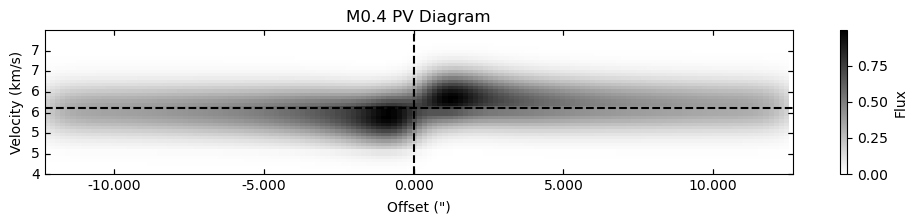

In [16]:
# Open FITS file and extract data and WCS
with fits.open(HOPS164_M04_pvdiagram) as hdul:
    pv_data = hdul[0].data
    pv_header = hdul[0].header
    wcs_pv = WCS(pv_header)

# Plot PV Diagram
fig, ax2 = plt.subplots(1, 1, subplot_kw={'projection': wcs_pv}, figsize=(10, 8))

# Display the image
im2 = ax2.imshow(pv_data, origin='lower', cmap='binary', aspect='auto')
plt.colorbar(im2, ax=ax2, label='Flux')

# Set labels
ax2.set_title("M0.4 PV Diagram")
ax2.set_xlabel('Offset (")')
ax2.set_ylabel('Velocity (km/s)')

# Format axes units
ax0 = ax2.coords[0]
ax0.set_format_unit(u.arcsec, decimal=True, show_decimal_unit=True)
ax1 = ax2.coords[1]
ax1.set_format_unit(u.km / u.s, decimal=True, show_decimal_unit=True)

# Set limits
ax2.set_ylim(wcs_pv.wcs_world2pix([[0, 4e3], [0, 7.5e3]], 0)[:,1])

# Get y at center to use in conversion
y_center = pv_data.shape[0] // 2
x0_pix = wcs_pv.wcs_world2pix([[0, y_center]], 0)[0][0]

ax2.axvline(x=x0_pix, color='black', linestyle='--', label='0″ Offset')

# Convert 5.6 km/s to m/s for WCS (if your WCS is in m/s)
velocity_mps = 5.6 * 1000
x_center = pv_data.shape[1] // 2
y56_pix = wcs_pv.wcs_world2pix([[x_center, velocity_mps]], 0)[0][1]

ax2.axhline(y=y56_pix, color='black', linestyle='--', label='5.6 km/s')

# Move ticks inside
ax2.tick_params(axis='both', direction='in', which='both')

# Plot
plt.tight_layout()
plt.show()